In [1]:
import teleloggingbot
import pprint

import numpy as np
import pandas as pd
from scipy.stats import gmean
from pandas.tools.plotting import scatter_matrix

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,20)
import seaborn as sns
sns.set(style="white")

from sklearn.metrics import log_loss, make_scorer, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_selection import RFECV
import tqdm

import xgboost

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from scipy.stats import norm, pearsonr
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 80) 
pd.set_option('display.max_rows', 10) 

%matplotlib inline

Using TensorFlow backend.


In [2]:
xdf_train = pd.read_csv('./x_train.csv', sep=';')
ydf_train = pd.read_csv('./y_train.csv', header=None)
xdf_test = pd.read_csv('./x_test.csv', sep=';')
ydf_train.columns = ['class']

In [3]:
data = pd.concat([xdf_train, ydf_train], axis=1)

In [4]:
xdf_train['totNumAttempts_/_nBoostersUsed'] = xdf_train['totalNumOfAttempts'] / \
    (1e-6+xdf_train['numberOfBoostersUsed'])
xdf_test['totNumAttempts_/_nBoostersUsed'] = xdf_test['totalNumOfAttempts'] / \
    (1e-6+xdf_test['numberOfBoostersUsed'])

xdf_train['avgNTurns_/_NDaysActuallyPlayed'] = xdf_train['averageNumOfTurnsPerCompletedLevel'] / \
    (1e-6+xdf_train['numberOfDaysActuallyPlayed'])
xdf_test['avgNTurns_/_NDaysActuallyPlayed'] = xdf_test['averageNumOfTurnsPerCompletedLevel'] / \
    (1e-6+xdf_test['numberOfDaysActuallyPlayed'])

xdf_train['nAttemptedLevels_/_totalNAttempts'] =  xdf_train['numberOfAttemptedLevels'] / \
    (1e-6+xdf_train['totalNumOfAttempts'])
xdf_test['nAttemptedLevels_/_totalNAttempts'] =  xdf_test['numberOfAttemptedLevels'] / \
    (1e-6+xdf_test['totalNumOfAttempts'])

xdf_train['maxPlayerLvl_/_avgNTurnPerCompletedLvl'] = \
    xdf_train['maxPlayerLevel'] / (1e-6+xdf_train['averageNumOfTurnsPerCompletedLevel'])
xdf_test['maxPlayerLvl_/_avgNTurnPerCompletedLvl'] = \
    xdf_test['maxPlayerLevel'] / (1e-6+xdf_test['averageNumOfTurnsPerCompletedLevel'])
    
xdf_train['maxLvl_/_BoostersUsed'] =  xdf_train['maxPlayerLevel'] / (1e-6 + xdf_train['numberOfBoostersUsed'])
xdf_test['maxLvl_/_BoostersUsed'] =  xdf_test['maxPlayerLevel'] / (1e-6 + xdf_test['numberOfBoostersUsed'])

xdf_train['totBonusScore_/_StarsCnt'] =  xdf_train['totalBonusScore'] / (1e-6 + xdf_train['totalStarsCount'])
xdf_test['totBonusScore_/_StarsCnt'] =  xdf_test['totalBonusScore'] / (1e-6 + xdf_test['totalStarsCount'])

xdf_train['totScore_/_StarsCnt'] =  xdf_train['totalScore'] / (xdf_train['totalBonusScore']+1e-6)
xdf_test['totScore_/_StarsCnt'] =  xdf_test['totalScore'] / (xdf_test['totalBonusScore']+1e-6)

xdf_train['levels_/_days'] =  xdf_train['numberOfAttemptedLevels'] / xdf_train['numberOfDaysActuallyPlayed']
xdf_test['levels_/_days'] =  xdf_test['numberOfAttemptedLevels'] / xdf_test['numberOfDaysActuallyPlayed']

xdf_train['attemptsHigherLvl_/_totAttempts'] = xdf_train['attemptsOnTheHighestLevel'] / xdf_train['totalNumOfAttempts']
xdf_test['attemptsHigherLvl_/_totAttempts'] = xdf_test['attemptsOnTheHighestLevel'] / xdf_test['totalNumOfAttempts']

xdf_train['nDaysPlayd*nAttempts'] = xdf_train['numberOfDaysActuallyPlayed'] * xdf_train['totalNumOfAttempts']
xdf_test['nDaysPlayd*nAttempts'] = xdf_test['numberOfDaysActuallyPlayed'] * xdf_test['totalNumOfAttempts']

xdf_train['nDaysPlayd*avgNTurns'] = xdf_train['numberOfDaysActuallyPlayed'] * xdf_train['averageNumOfTurnsPerCompletedLevel']
xdf_test['nDaysPlayd*avgNTurns'] = xdf_test['numberOfDaysActuallyPlayed'] * xdf_test['averageNumOfTurnsPerCompletedLevel']

xdf_train['nDaysPlayd*maxLvl'] = xdf_train['numberOfDaysActuallyPlayed'] * xdf_train['maxPlayerLevel']
xdf_test['nDaysPlayd*maxLvl'] = xdf_test['numberOfDaysActuallyPlayed'] * xdf_test['maxPlayerLevel']

xdf_train['totNAttempts*nTurns'] = xdf_train['totalNumOfAttempts'] * xdf_train['averageNumOfTurnsPerCompletedLevel']
xdf_test['totNAttempts*nTurns'] = xdf_test['totalNumOfAttempts'] * xdf_test['averageNumOfTurnsPerCompletedLevel']

xdf_train['Boosters*nTurns'] = xdf_train['numberOfBoostersUsed'] * xdf_train['averageNumOfTurnsPerCompletedLevel']
xdf_test['Boosters*nTurns'] = xdf_test['numberOfBoostersUsed'] * xdf_test['averageNumOfTurnsPerCompletedLevel']

xdf_train['nAttempts*maxLvl'] = xdf_train['totalNumOfAttempts'] * xdf_train['maxPlayerLevel']
xdf_test['nAttempts*maxLvl'] = xdf_test['totalNumOfAttempts'] * xdf_test['maxPlayerLevel']

xdf_train['nAttempts*maxLvl'] = xdf_train['totalNumOfAttempts'] * xdf_train['maxPlayerLevel']
xdf_test['nAttempts*maxLvl'] = xdf_test['totalNumOfAttempts'] * xdf_test['maxPlayerLevel']

xdf_train['nAttempts*fractBoosters'] = xdf_train['totalNumOfAttempts'] * xdf_train['fractionOfUsefullBoosters']
xdf_test['nAttempts*fractBoosters'] = xdf_test['totalNumOfAttempts'] * xdf_test['fractionOfUsefullBoosters']

xdf_train['nPlayed*totScore'] = xdf_train['numberOfDaysActuallyPlayed'] * xdf_train['totalScore']
xdf_test['nPlayed*totScore'] = xdf_test['numberOfDaysActuallyPlayed'] * xdf_test['totalScore']

xdf_train['BoostersUsed*totScore'] = xdf_train['totalScore'] * xdf_train['numberOfBoostersUsed']
xdf_test['BoostersUsed*totScore'] = xdf_test['totalScore'] * xdf_test['numberOfBoostersUsed']



xdf_train['diff_NofDaysPlayed_BoostersFraction'] = xdf_train['numberOfDaysActuallyPlayed'] - xdf_train['fractionOfUsefullBoosters']
xdf_test['diff_NofDaysPlayed_BoostersFraction'] = xdf_test['numberOfDaysActuallyPlayed'] - xdf_test['fractionOfUsefullBoosters']

xdf_train['diff_NofDaysPlayed_doReturns'] = xdf_train['numberOfDaysActuallyPlayed'] - xdf_train['doReturnOnLowerLevels']
xdf_test['diff_NofDaysPlayed_doReturns'] = xdf_test['numberOfDaysActuallyPlayed'] - xdf_test['doReturnOnLowerLevels']

xdf_train['diff_totNOfAttempts_nOfAttemptedLvls'] = xdf_train['totalNumOfAttempts'] - xdf_train['numberOfAttemptedLevels']
xdf_test['diff_totNOfAttempts_nOfAttemptedLvls'] = xdf_test['totalNumOfAttempts'] - xdf_test['numberOfAttemptedLevels']


xdf_train['difference'] = xdf_train['maxPlayerLevel'] - xdf_train['numberOfAttemptedLevels']
xdf_test['difference'] = xdf_test['maxPlayerLevel'] - xdf_test['numberOfAttemptedLevels']


del xdf_train['numberOfAttemptedLevels']
del xdf_test['numberOfAttemptedLevels']

del xdf_train['doReturnOnLowerLevels']
del xdf_test['doReturnOnLowerLevels']
             
del xdf_train['fractionOfUsefullBoosters']
del xdf_test['fractionOfUsefullBoosters']

del xdf_train['totalStarsCount']
del xdf_test['totalStarsCount']
             
xdf_train['totNAttempts_/_totScore'] =  xdf_train['totalNumOfAttempts'] / (1e-6 + xdf_train['totalScore'])
xdf_test['totNAttempts_/_totScore'] =  xdf_test['totalNumOfAttempts'] / (1e-6 + xdf_test['totalScore'])


In [5]:
scaler = StandardScaler()
scaler.fit(pd.concat((xdf_train, xdf_test)))

xtrain = scaler.transform(xdf_train)
xtest = scaler.transform(xdf_test)

In [6]:
feat_columns = list(xdf_train.columns)
pprint.pprint(feat_columns)

['maxPlayerLevel',
 'attemptsOnTheHighestLevel',
 'totalNumOfAttempts',
 'averageNumOfTurnsPerCompletedLevel',
 'numberOfBoostersUsed',
 'totalScore',
 'totalBonusScore',
 'numberOfDaysActuallyPlayed',
 'totNumAttempts_/_nBoostersUsed',
 'avgNTurns_/_NDaysActuallyPlayed',
 'nAttemptedLevels_/_totalNAttempts',
 'maxPlayerLvl_/_avgNTurnPerCompletedLvl',
 'maxLvl_/_BoostersUsed',
 'totBonusScore_/_StarsCnt',
 'totScore_/_StarsCnt',
 'levels_/_days',
 'attemptsHigherLvl_/_totAttempts',
 'nDaysPlayd*nAttempts',
 'nDaysPlayd*avgNTurns',
 'nDaysPlayd*maxLvl',
 'totNAttempts*nTurns',
 'Boosters*nTurns',
 'nAttempts*maxLvl',
 'nAttempts*fractBoosters',
 'nPlayed*totScore',
 'BoostersUsed*totScore',
 'diff_NofDaysPlayed_BoostersFraction',
 'diff_NofDaysPlayed_doReturns',
 'diff_totNOfAttempts_nOfAttemptedLvls',
 'difference',
 'totNAttempts_/_totScore']


In [7]:
# n_clusters = 0
# kmeans = KMeans(n_clusters=n_clusters,
#                 init='k-means++',
#                 max_iter=1000,
#                 n_init=10).fit(np.vstack([xtrain, xtest]))

# scaler = StandardScaler()
# scaler.fit(np.vstack([kmeans.transform(xtrain), kmeans.transform(xtest)]))

# xtrain = np.hstack([xtrain, scaler.transform(kmeans.transform(xtrain))])
# xtest = np.hstack([xtest, scaler.transform(kmeans.transform(xtest))])
# feat_columns += ['cluster_'+str(i+1) for i in range(n_clusters)]

In [8]:
xgb_matrix = xgboost.DMatrix(xtrain, ydf_train.values.ravel(), feature_names=feat_columns)
xgb_param = {
    'colsample_bylevel': 0.5,
    'colsample_bytree': 0.7,
    'gamma': 5.65,
    'learning_rate': 0.01,
    'max_delta_step': 5.1,
    'max_depth': 4,
    'min_child_weight': 7.0,
    'n_estimators': 5000,
    'nthread': 8,
    'objective': 'binary:logistic',
    'reg_lambda': 1.65,
    'scale_pos_weight': 1.0,
    'silent': 1,
    'seed': 42,
    'subsample': 0.5
}

In [9]:
%%time
cvresult = xgboost.cv(xgb_param, xgb_matrix, num_boost_round=xgb_param['n_estimators']+1,
                      nfold=5, verbose_eval=50, stratified=True, early_stopping_rounds=50,
                      metrics='logloss', seed=42,)
print('Done.')
xgb_param['n_estimators'] = len(cvresult)
print('Final logloss: {:.6} +- {:.6}'.format(cvresult['test-logloss-mean'].iloc[-1],
                                             cvresult['test-logloss-std'].iloc[-1]))
# teleloggingbot.sendMsg('Done xgboost CV! logloss: {}\n{}'.format(
#     cvresult['test-logloss-mean'].iloc[-1], pprint.pformat(xgb_param, indent=4)))

[0]	train-logloss:0.688036+2.12603e-05	test-logloss:0.688073+4.09956e-05
[50]	train-logloss:0.521464+0.00045206	test-logloss:0.523127+0.00113901
[100]	train-logloss:0.446668+0.000600369	test-logloss:0.449576+0.00180784
[150]	train-logloss:0.410233+0.000823109	test-logloss:0.414258+0.00214545
[200]	train-logloss:0.391895+0.000917236	test-logloss:0.396907+0.00242371
[250]	train-logloss:0.382476+0.000928643	test-logloss:0.388401+0.00278746
[300]	train-logloss:0.377439+0.00100431	test-logloss:0.384185+0.00300306
[350]	train-logloss:0.374674+0.000964294	test-logloss:0.382169+0.00325295
[400]	train-logloss:0.373025+0.000973821	test-logloss:0.381209+0.00341884
[450]	train-logloss:0.371832+0.000965596	test-logloss:0.380722+0.00352191
[500]	train-logloss:0.37082+0.000978626	test-logloss:0.380461+0.00360861
[550]	train-logloss:0.36995+0.000951644	test-logloss:0.380309+0.00362166
[600]	train-logloss:0.36923+0.000946171	test-logloss:0.380214+0.00369773
[650]	train-logloss:0.368496+0.00092662	test-

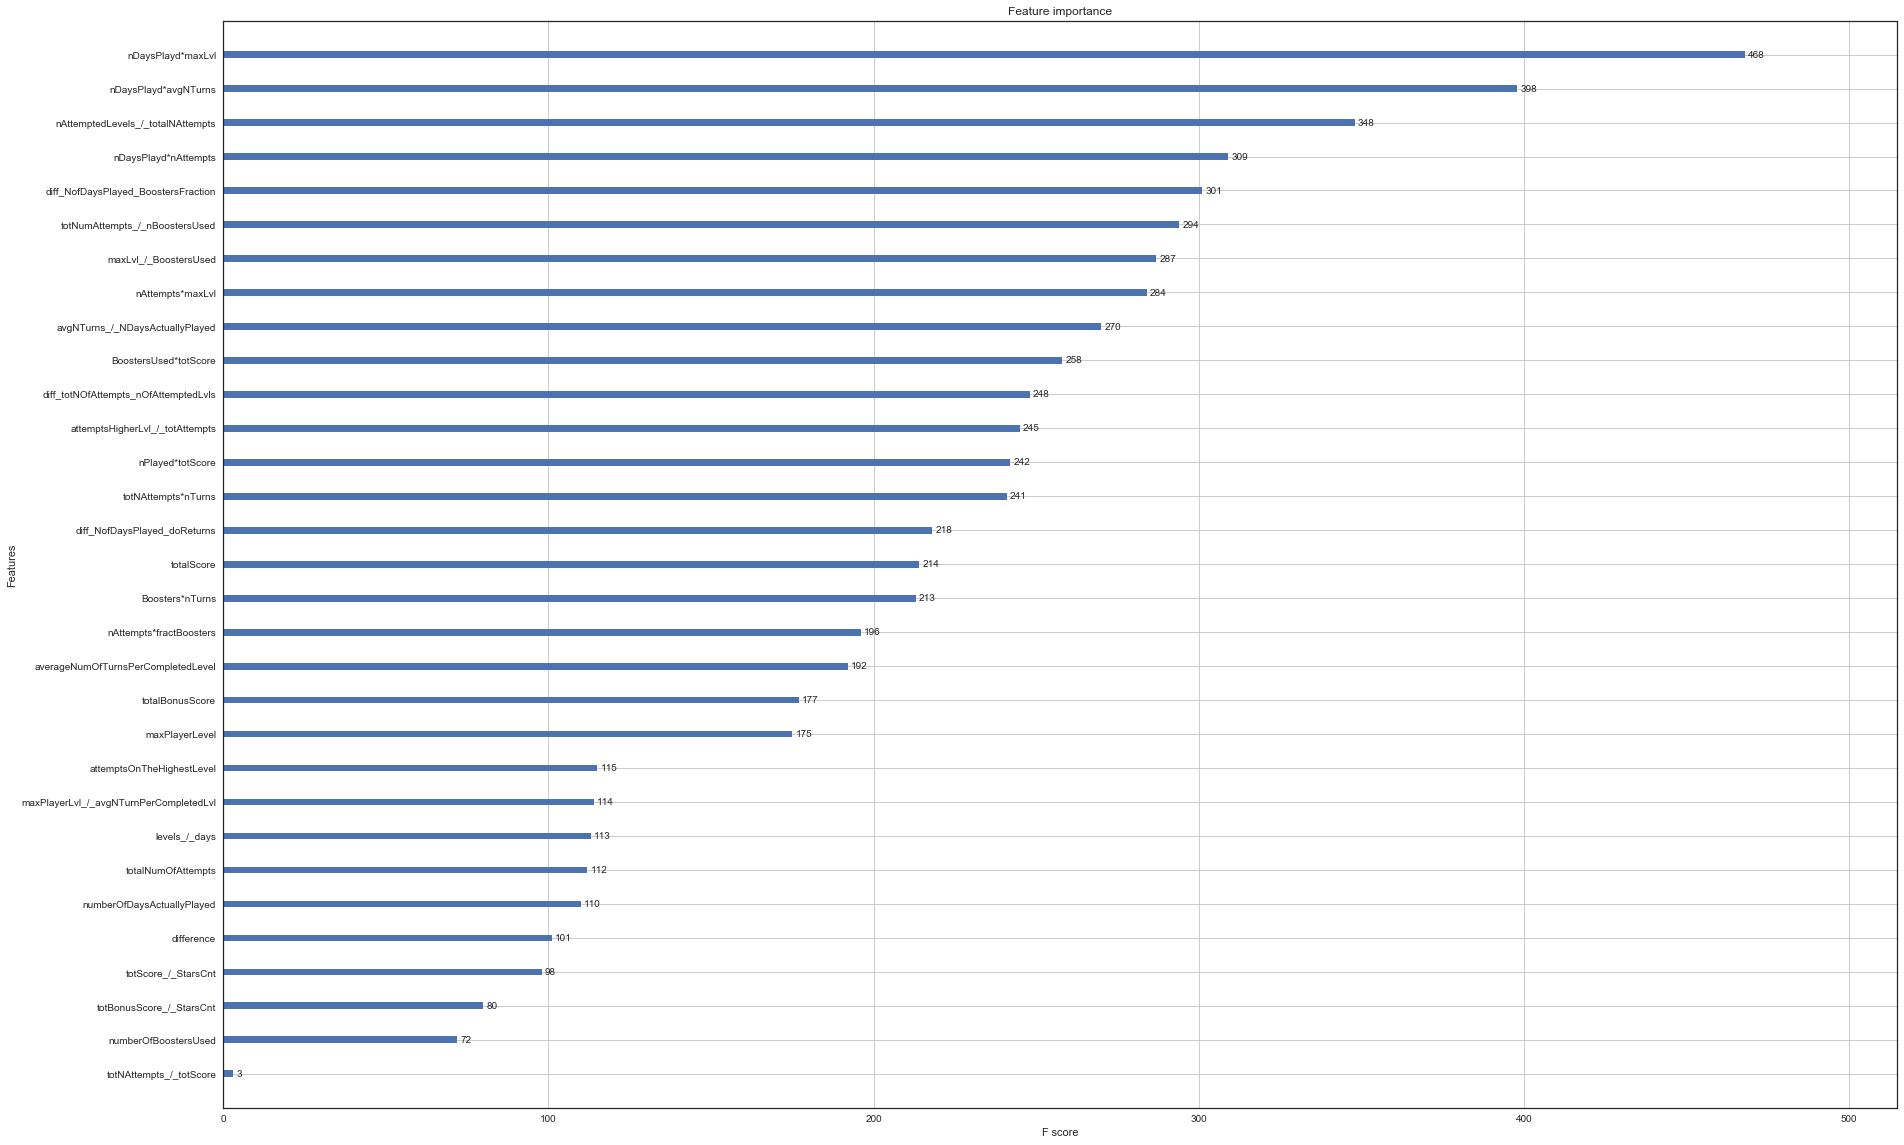

In [10]:
gbm = xgboost.XGBClassifier(**xgb_param)
gbm.fit(xtrain, ydf_train.values.ravel())
gbm.booster().feature_names = feat_columns
fig, ax = plt.subplots(figsize=(30, 20))
xgboost.plot_importance(gbm, ax=ax);

In [ ]:
def wgmean(xs, ws=None):
    if not ws: ws = [1.0 for i in range(len(xs))]
    xs = np.concatenate(xs, axis=1)
    prod = np.prod(np.power(xs, ws), axis=1).reshape(-1, 1)
    return np.power(prod, (1.0/np.sum(ws)))